In [1]:
import csv
import math
import pickle
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
from sklearn.cross_decomposition import PLSRegression

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button style="color:"black";right:75%;" onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [3]:
######################################################################## ALL USER DEFINED FUNCTION ARE LOGGED HERE #############################################################################
################################################################################################################################################################################################

# calculate rmse scores
def rmse(pred_test, y_test):
    return - np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# get names of all categorical data present in data
def get_index_of_categorical_columns(df):
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    return list(set(cols) - set(num_cols))


def do_union(lst1, lst2, lst3, lst4): 
    final_list = list(set(lst1) | set(lst2) | set(lst3) | set(lst4))
    return final_list 

In [7]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################
####### Load ADS using name and path
#### Put name of the file as ads_name : name_of_my_ads
### Put the path is ads name : aes-analytics-0001-notebooks/Outage Restoration/Offshore_Gourav/CSV repo/

load_ads = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_OUTAGE_V10.4_IQR_08092020.csv')
load_ads.head()
print(list(load_ads.columns))

['DNI_EQUIP_TYPE', 'CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_O

In [8]:
object_columns = load_ads.loc[:, (load_ads.dtypes == object) | (load_ads.dtypes == bool)]
print(list(object_columns.columns))

['DNI_EQUIP_TYPE', 'DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', '

In [10]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################

select_columns_from_ads = ['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG',
                           'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                           'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 
                           'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 
                           'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG',
                           'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                           'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 
                           'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 
                           'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0',
                           'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 'ZONE', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY',
                           'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OUTAGES', 
                           'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr',
                           'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Weekday', 'Weekend_flag',
                           'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty', 'Dispatch_Location', 'cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 
                           'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg',
                           'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 
                           'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBulbMax',
                           'wetBulbMin', 'windChillAvg', 'windChillMax', 'windChillMin', 'windDir100mAvg', 'windDir80mAvg', 'windDirAvg', 'windSpd100mAvg',
                           'windSpd100mMax', 'windSpd100mMin', 'windSpd80mAvg', 'windSpd80mMax', 'windSpd80mMin', 'windSpdAvg', 'windSpdMax', 'windSpdMin', 
                           'tempRange', 'windSpdRange', 'sfcPresRange', 'cldCvrRange', 'relHumRange', 'relHumRatio', 'sfcPresRatio']

ads = load_ads[select_columns_from_ads]

ads = pd.get_dummies(ads, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 
                                   'ZONE', 'Weekday', 'Weekend_flag', 'Dispatch_Location'])

In [11]:
# print list of columns present in the ads and drop na's from the dataset
print(list(ads.columns))
ads.dropna(inplace=True)
print(ads.shape)

['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'TTR', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OUTAGES', 'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr', 'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty', 'cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg', 'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBu

#### **Target Variable Analysis: Is it Normal?**

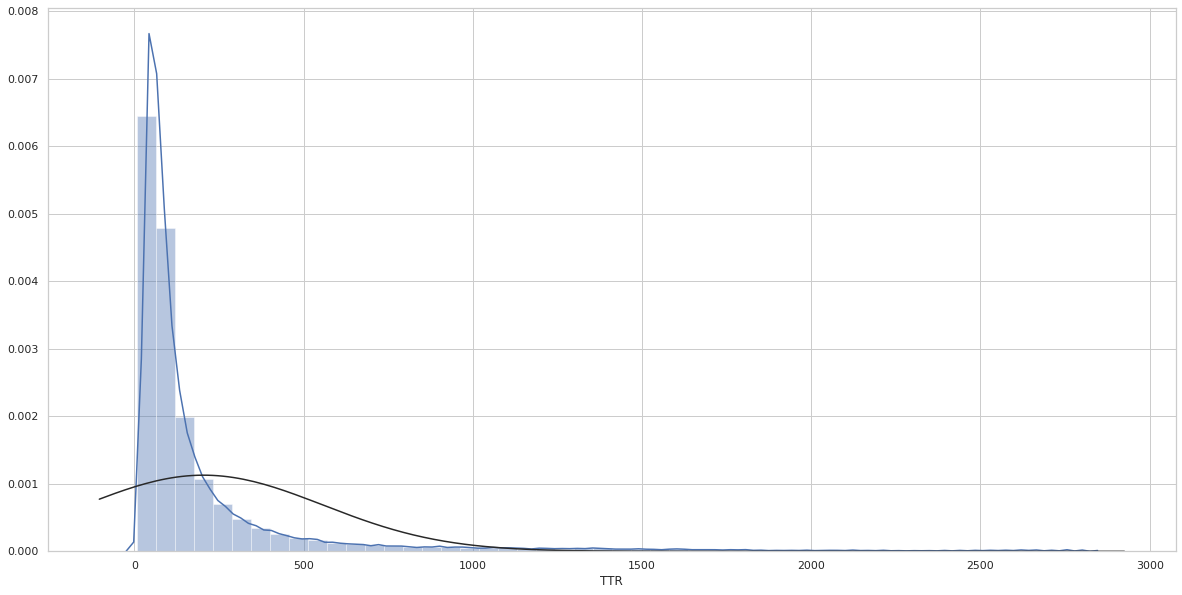

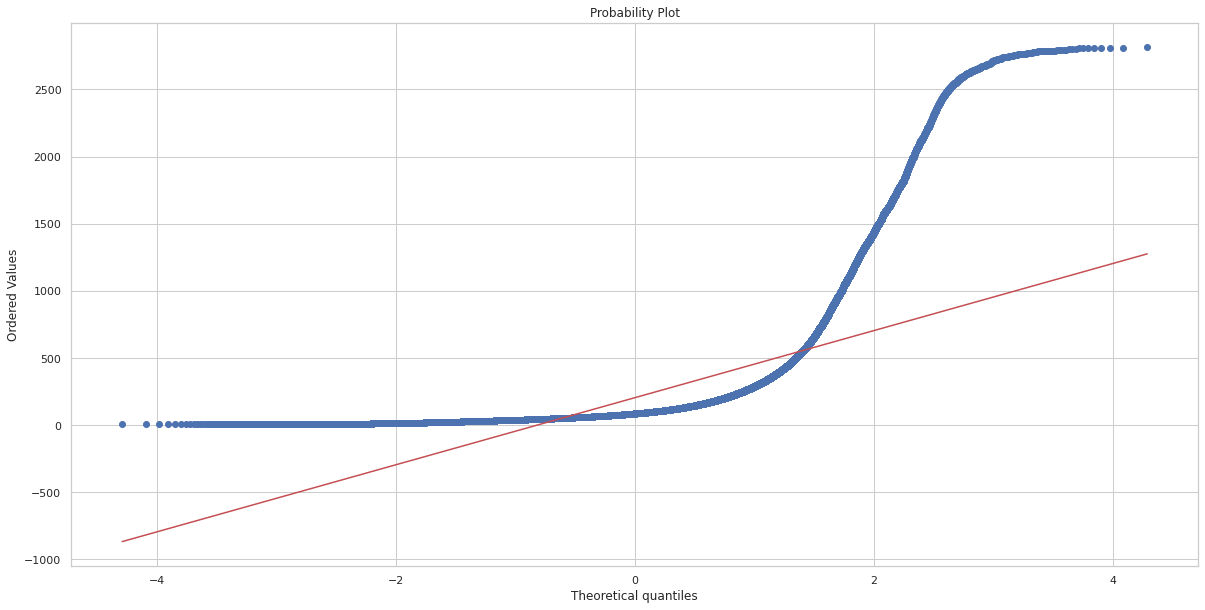

In [12]:
from scipy.stats import norm

sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("whitegrid")

sns.distplot(ads['TTR'],fit=norm);
fig = plt.figure()
print('\n')
print('\n')
res = stats.probplot(ads['TTR'], plot=plt)

#### **Log Transformation of TTR**

In [13]:
# Apply log e tranformation to the dataset
ads['TTR'] = np.log(ads['TTR'])

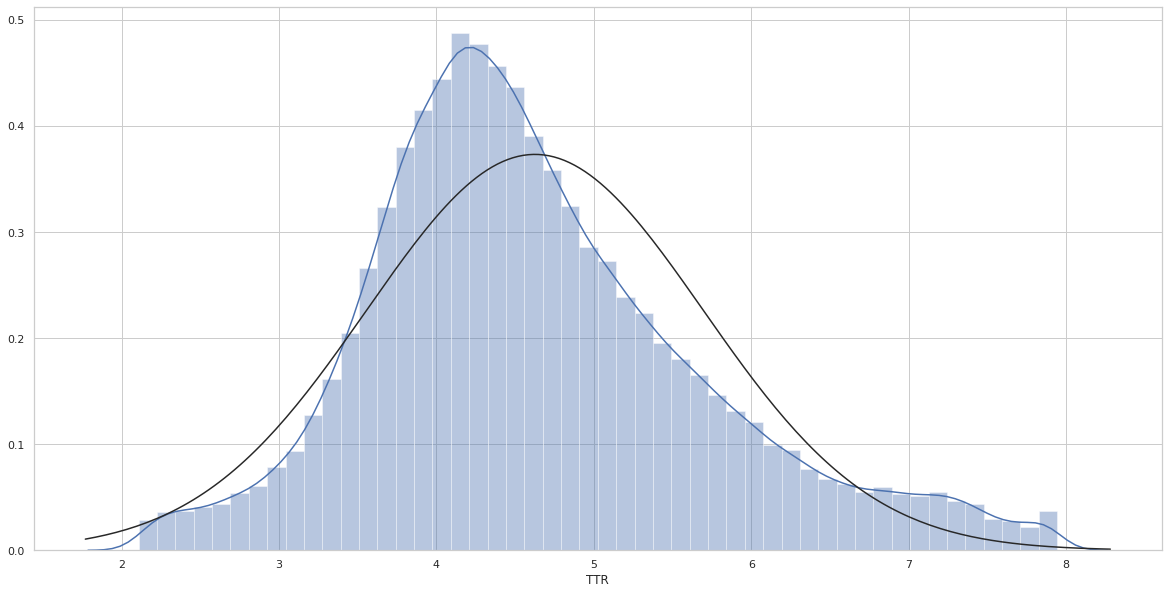

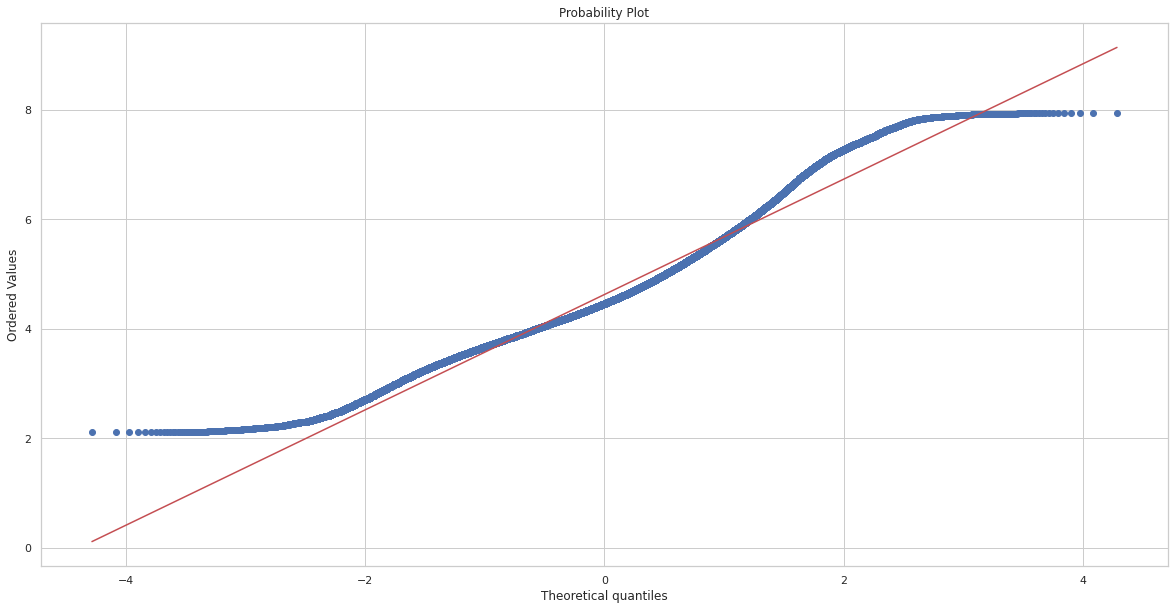

In [14]:
from scipy.stats import norm

sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("whitegrid")

sns.distplot(ads['TTR'],fit=norm);
fig = plt.figure()
print('\n')
print('\n')
res = stats.probplot(ads['TTR'], plot=plt)

In [ ]:
#########################################################################################################################################################################################################
######################################################################## FEATURE SELECTION : MAX VOTING REGIME ##########################################################################################


X = ads.drop(['TTR'],axis=1)
y = ads['TTR']

xg = xgb.XGBRegressor()
xg.fit(X,y)
rf = RandomForestRegressor()
rf.fit(X,y)
lg = lgb.LGBMRegressor()
lg.fit(X,y)
cb = cb.CatBoostRegressor(silent = True)
cb.fit(X,y)

xgboost = pd.DataFrame({'Features': X.columns, 'Importance_Score_XGBoost': xg.feature_importances_}).sort_values(by='Importance_Score_XGBoost',ascending=False)
rftrees = pd.DataFrame({'Features': X.columns, 'Importance_Score_Random_Forest': rf.feature_importances_}).sort_values(by='Importance_Score_Random_Forest',ascending=False)
lightgbm = pd.DataFrame({'Features': X.columns, 'Importance_Score_Light_GBM': lg.feature_importances_}).sort_values(by='Importance_Score_Light_GBM',ascending=False)
catboost = pd.DataFrame({'Features': X.columns, 'Importance_Score_CatBoost': cb.feature_importances_}).sort_values(by='Importance_Score_CatBoost',ascending=False)
xgboost.reset_index(drop=True,inplace=True)
rftrees.reset_index(drop=True,inplace=True)
lightgbm.reset_index(drop=True,inplace=True)
catboost.reset_index(drop=True,inplace=True)

xgboost = xgboost.head(20)
rftrees = rftrees.head(20)
lightgbm = lightgbm.head(20)
catboost = catboost.head(20)

In [16]:
display(rftrees)
print('\n')
print('\n')

,Features,Importance_Score_Random_Forest
0,NO_OF_POWER_OUT_CLUE_PER_DAY,0.227403
1,Priority_Customer_Qty,0.077600
2,NO_OF_WIRE_OCCURN_PER_DAY,0.056210
3,DOWNSTREAM_CUST_QTY,0.040202
4,CALL_QTY,0.036924
5,PUBLIC_SAFETY_OCCURN_FLG_True,0.029102
6,Priority_Dist_Customer_Qty,0.027794
7,ANIMAL_CAUSE_FLG_True,0.022440
8,Outages_in_last_1hr,0.020981
9,PUBLIC_SAFETY_OCCURN_FLG_False,0.014137


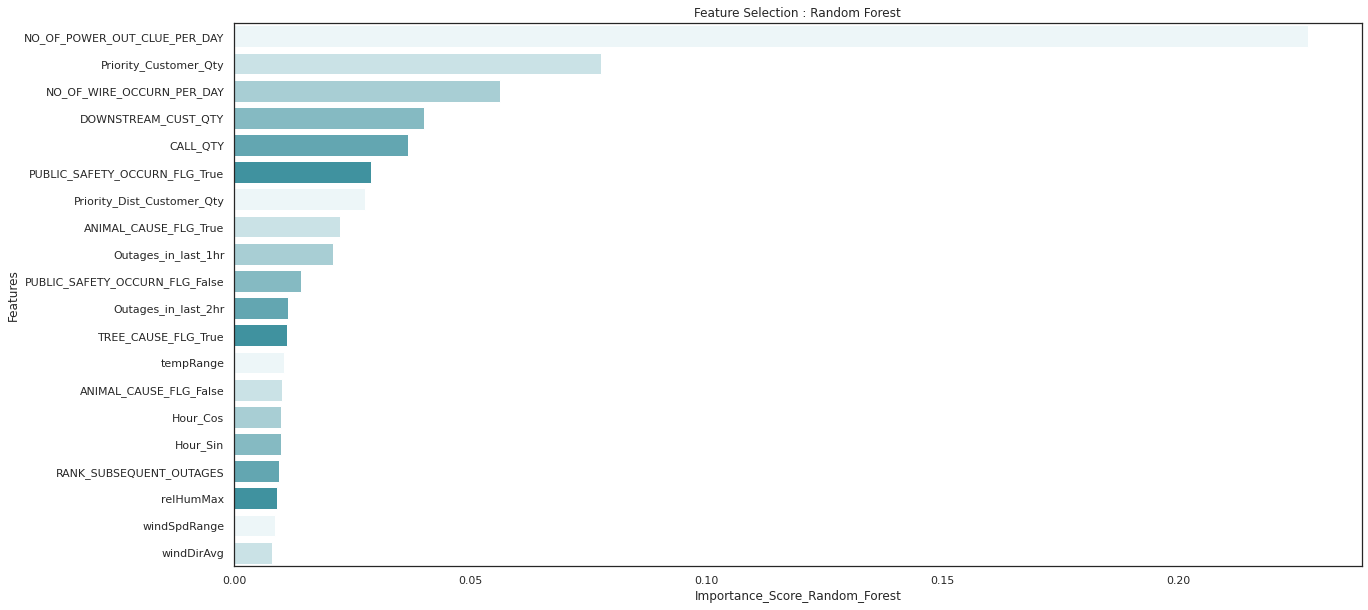

In [17]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_Random_Forest", y="Features", data=rftrees, palette = sns.light_palette((210, 90, 60), input="husl")).set_title('Feature Selection : Random Forest')

In [18]:
display(xgboost)
print('\n')
print('\n')

,Features,Importance_Score_XGBoost
0,NO_OF_POWER_OUT_CLUE_PER_DAY,0.136459
1,NO_OF_WIRE_OCCURN_PER_DAY,0.104273
2,ANIMAL_CAUSE_FLG_False,0.093799
3,PUBLIC_SAFETY_OCCURN_FLG_False,0.065253
4,Outages_in_last_1hr,0.052365
5,TREE_CAUSE_FLG_False,0.034891
6,Priority_Customer_Qty,0.033330
7,WIRE_OCCURN_FLG_False,0.028109
8,POWER_OUT_CLUE_FLG_False,0.025411
9,POLE_CLUE_FLG_False,0.017331


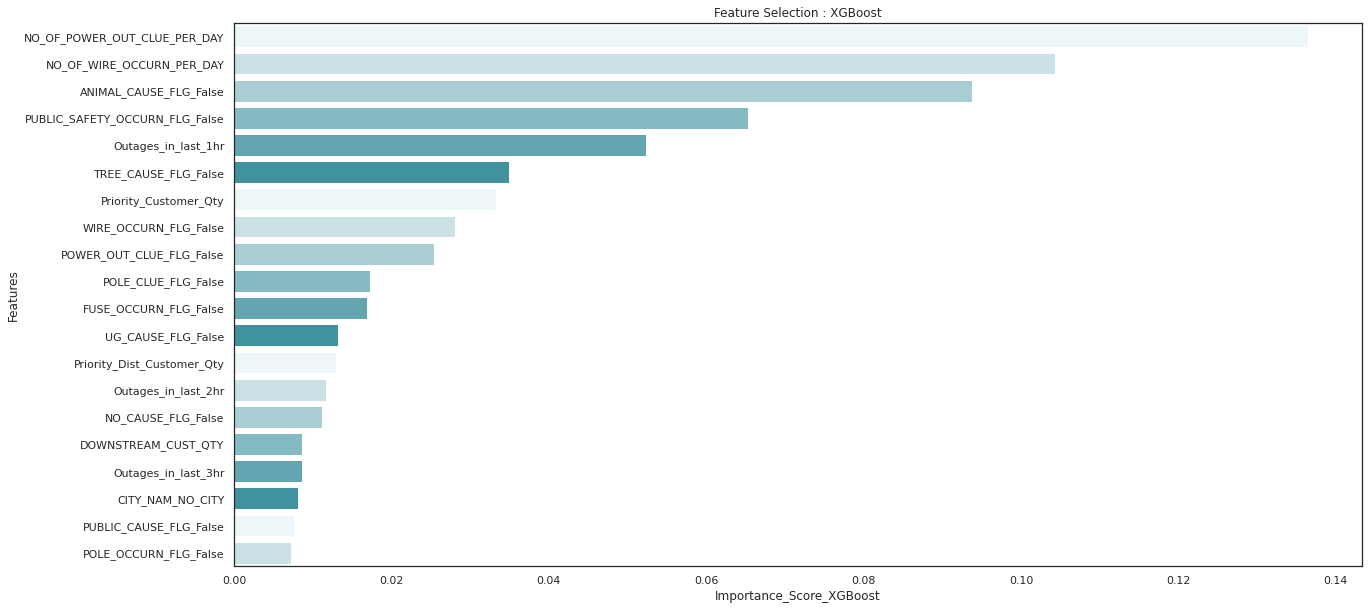

In [19]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_XGBoost", y="Features", data=xgboost, palette = sns.light_palette((210, 90, 60), input="husl")).set_title('Feature Selection : XGBoost')

In [20]:
display(lightgbm)
print('\n')
print('\n')

,Features,Importance_Score_Light_GBM
0,DOWNSTREAM_CUST_QTY,342
1,CALL_QTY,306
2,Priority_Customer_Qty,144
3,Hour_Cos,83
4,Hour_Sin,73
5,Priority_Dist_Customer_Qty,70
6,OPEN_DEVICE_CLUE_FLG_False,70
7,NO_OF_WIRE_OCCURN_PER_DAY,68
8,RANK_SUBSEQUENT_OUTAGES,59
9,PUBLIC_SAFETY_OCCURN_FLG_False,59


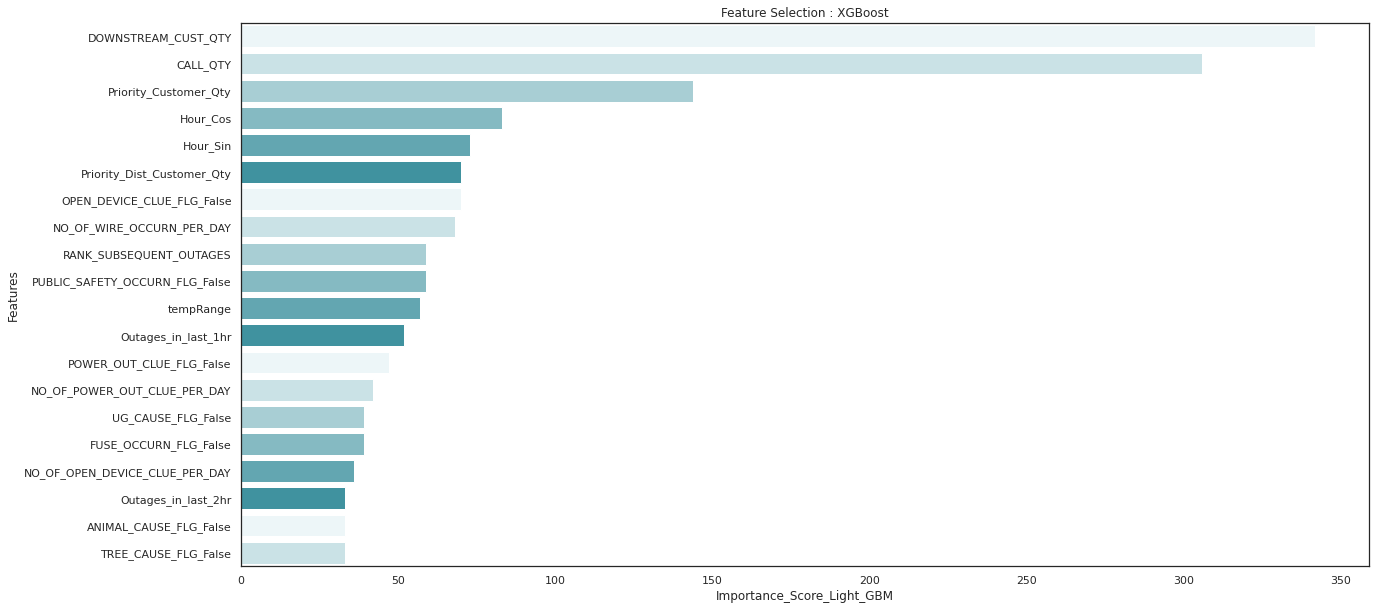

In [21]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_Light_GBM", y="Features", data=lightgbm , palette = sns.light_palette((210, 90, 60), input="husl")).set_title('Feature Selection : XGBoost')

In [22]:
display(lightgbm)
print('\n')
print('\n')

,Features,Importance_Score_Light_GBM
0,DOWNSTREAM_CUST_QTY,342
1,CALL_QTY,306
2,Priority_Customer_Qty,144
3,Hour_Cos,83
4,Hour_Sin,73
5,Priority_Dist_Customer_Qty,70
6,OPEN_DEVICE_CLUE_FLG_False,70
7,NO_OF_WIRE_OCCURN_PER_DAY,68
8,RANK_SUBSEQUENT_OUTAGES,59
9,PUBLIC_SAFETY_OCCURN_FLG_False,59


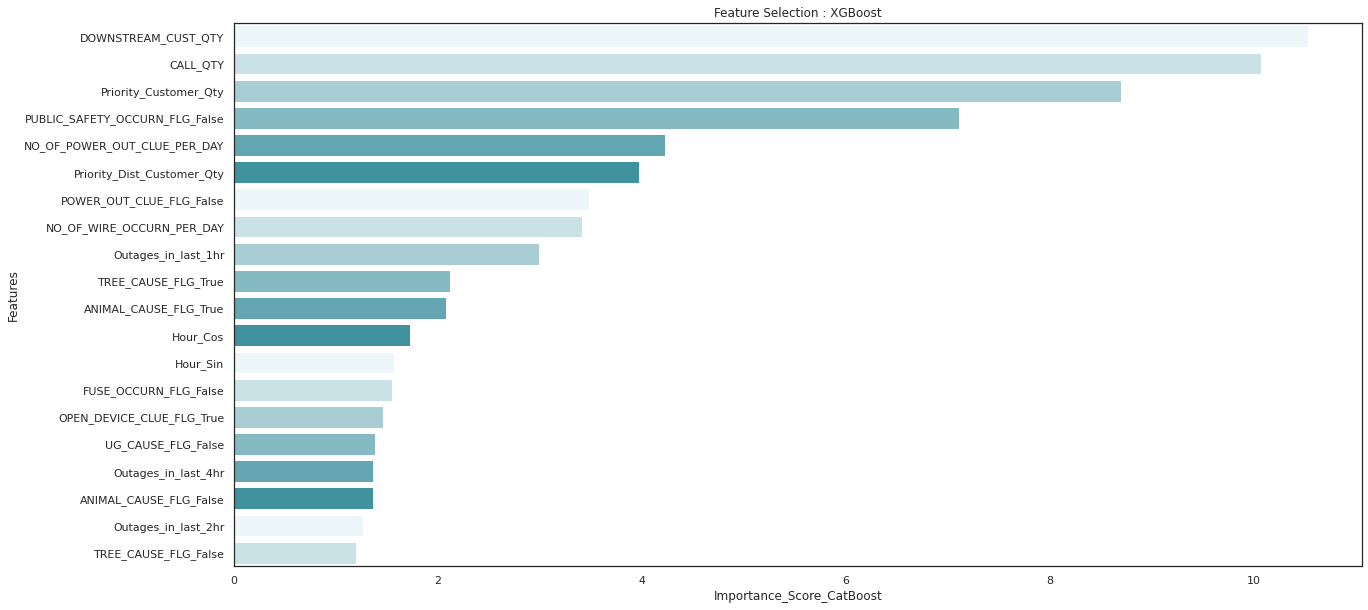

In [23]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_CatBoost", y="Features", data=catboost, palette = sns.light_palette((210, 90, 60), input="husl")).set_title('Feature Selection : XGBoost')

In [24]:
final_features = do_union(list(xgboost.Features), list(rftrees.Features), list(lightgbm.Features), list(catboost.Features))

print('\n')
print('\n')

display(final_features)

print('\n')
print('\n')

['ANIMAL_CAUSE_FLG_False',
 'CITY_NAM_NO_CITY',
 'TREE_CAUSE_FLG_False',
 'Hour_Cos',
 'POLE_CLUE_FLG_False',
 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY',
 'DOWNSTREAM_CUST_QTY',
 'RANK_SUBSEQUENT_OUTAGES',
 'Outages_in_last_2hr',
 'windSpdRange',
 'windDirAvg',
 'NO_CAUSE_FLG_False',
 'NO_OF_POWER_OUT_CLUE_PER_DAY',
 'CALL_QTY',
 'NO_OF_WIRE_OCCURN_PER_DAY',
 'FUSE_OCCURN_FLG_False',
 'Priority_Dist_Customer_Qty',
 'Outages_in_last_3hr',
 'OPEN_DEVICE_CLUE_FLG_False',
 'Hour_Sin',
 'WIRE_OCCURN_FLG_False',
 'PUBLIC_SAFETY_OCCURN_FLG_True',
 'Priority_Customer_Qty',
 'POWER_OUT_CLUE_FLG_False',
 'OPEN_DEVICE_CLUE_FLG_True',
 'tempRange',
 'PUBLIC_CAUSE_FLG_False',
 'POLE_OCCURN_FLG_False',
 'PUBLIC_SAFETY_OCCURN_FLG_False',
 'UG_CAUSE_FLG_False',
 'ANIMAL_CAUSE_FLG_True',
 'relHumMax',
 'Outages_in_last_4hr',
 'Outages_in_last_1hr',
 'TREE_CAUSE_FLG_True']

In [115]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################
# Enter Regression Model Names
# Update Regression Model List 
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

lr = sklearn.linear_model.LinearRegression()
pls = PLSRegression()
las = sklearn.linear_model.Lasso()
elas = sklearn.linear_model.ElasticNet()
rf = RandomForestRegressor(n_jobs=-1)
dt = DecisionTreeRegressor()
xgb = xgb.XGBRegressor(n_jobs=-1)
lgb = lgb.LGBMRegressor(n_jobs=-1)
cb = cb.CatBoostRegressor(silent = True)

models= [('lin_reg', lr), ('partial_least_squares', pls), ('lasso', las), ('elastic_net', elas), ('random forest', rf), ('decision tree', dt), ('xgboost', xgb),
         ('lightgbm', lgb), ('catboost', cb)]

In [124]:
# Define model and other needed metrics using a dataframe
# model result structure
# Store the all iteration results 

model_col = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
model_result_df = pd.DataFrame(columns=model_col)
data_list = pd.DataFrame() 

X = ads[final_features]
y = ads['TTR']


j=0
for i,model in models:
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = None
    y_pred = model.predict(X_test)
    
    # anti log y_test and y_pred values
    y_test = np.exp(y_test)
    y_pred = np.exp(y_pred)

    mse_test = mean_squared_error(y_test, y_pred)

    rmse_test = np.sqrt(mean_squared_error(y_test,y_pred))

    mae_test = mean_absolute_error(y_test, y_pred)

    mape_test = mean_absolute_percentage_error(y_test,y_pred)
    
    r2_test = r2_score(y_test,y_pred)

    data_val = pd.DataFrame({'Model':str(i), 'Predicted': list(y_pred),'Actual': list(y_test)})
    data_list = data_list.append(data_val)
    data_list.reset_index(drop=True, inplace=True)
    
    row = [str(i), mse_test, rmse_test, mae_test, mape_test, r2_test]
    model_result_df.loc[j] = row
    
    j = j + 1

lin_reg
partial_least_squares
lasso
elastic_net
random forest
decision tree
xgboost
lightgbm
catboost


In [138]:
display(model_result_df)

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,lin_reg,2.599886e+05,509.890762,132.425184,75.709783,-1.003131
1,partial_least_squares,1.436605e+05,379.025687,134.866753,195.443429,-0.106859
2,lasso,4.526809e+06,2127.629866,168.839852,98.059659,-33.877656
3,elastic_net,3.797003e+07,6161.982352,202.664361,108.117340,-291.547262
4,random forest,4.062571e+04,201.558206,92.691024,61.906337,0.686992
5,decision tree,6.732406e+04,259.468804,128.993335,108.105791,0.481289
6,xgboost,3.924640e+04,198.107052,91.653968,61.010360,0.697619
7,lightgbm,4.026976e+04,200.673255,92.624480,60.771808,0.689734
8,catboost,3.712379e+04,192.675341,89.944521,59.787281,0.713973


In [128]:
data_list.Model.value_counts()

partial_least_squares    15356
lasso                    15356
elastic_net              15356
lightgbm                 15356
random forest            15356
decision tree            15356
catboost                 15356
lin_reg                  15356
xgboost                  15356
Name: Model, dtype: int64

In [129]:
data_list['Predicted'] = pd.to_numeric(data_list['Predicted'], errors='coerce')

Text(0.5, 1.0, 'Actual vs Fitted : Random Forest')

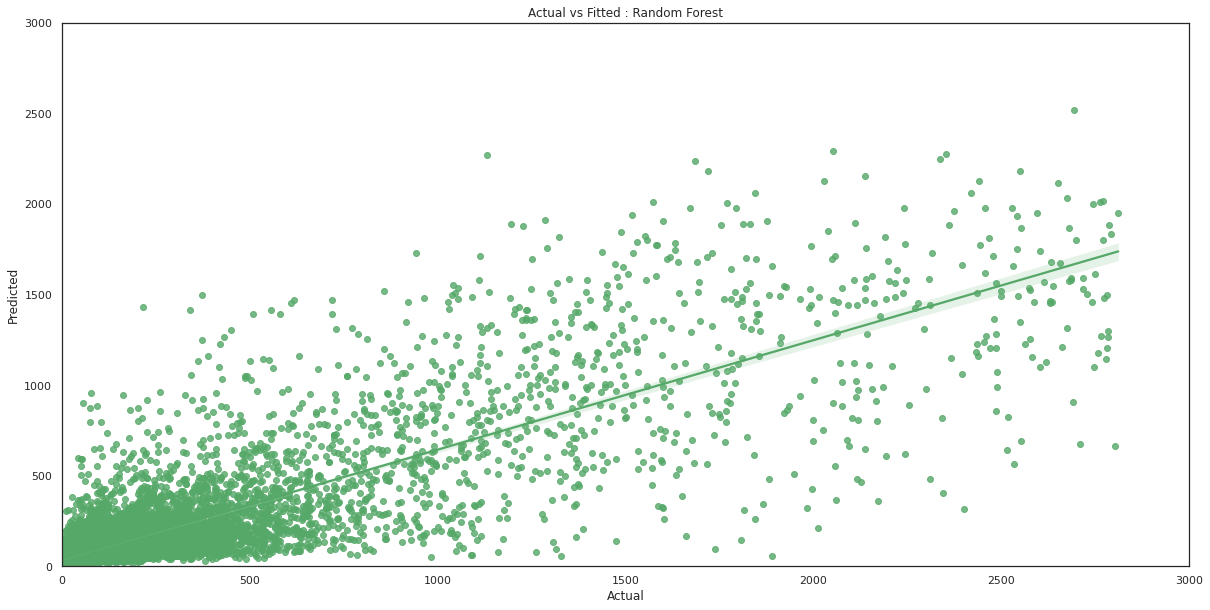

In [147]:
ax = sns.regplot(x="Actual", y="Predicted", data=data_list[data_list.Model=='random forest'], color="g")
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest')

Text(0.5, 1.0, 'Actual vs Fitted : XGBoost')

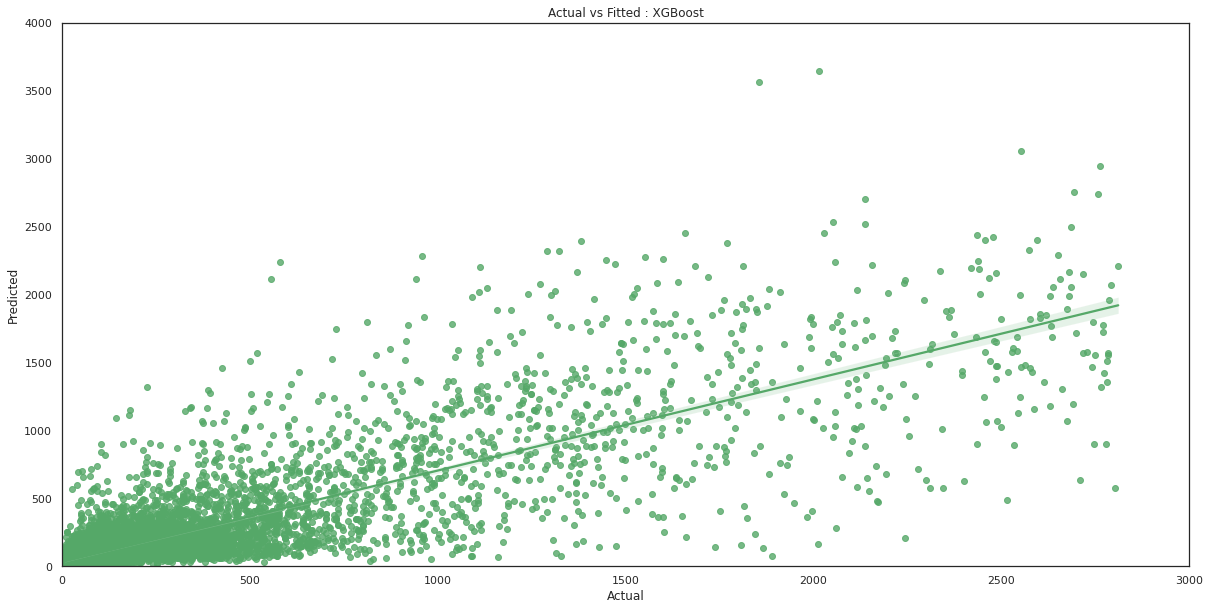

In [149]:
ax = sns.regplot(x="Actual", y="Predicted", data=data_list[data_list.Model=='xgboost'], color="g")
ax.set_xlim(0,3000)
ax.set_ylim(0,4000)
ax.set_title('Actual vs Fitted : XGBoost')

(0.0, 3000.0)

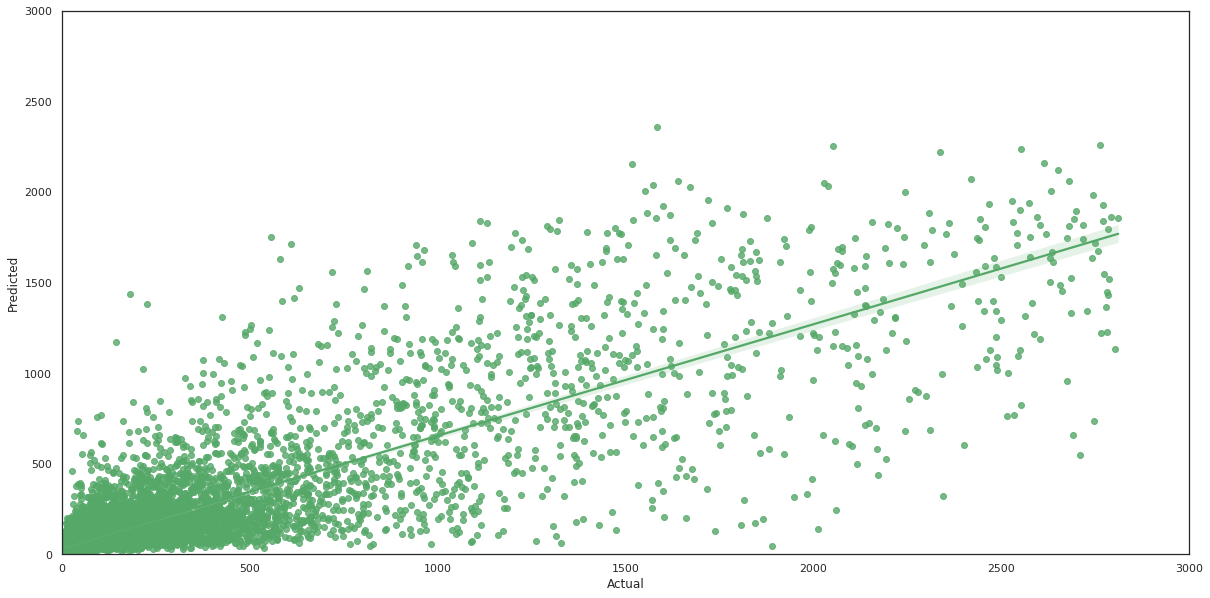

In [144]:
ax = sns.regplot(x="Actual", y="Predicted", data=data_list[data_list.Model=='lightgbm'], color="g")
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : LightGBM')

Text(0.5, 1.0, 'Actual vs Fitted : CatBoost')

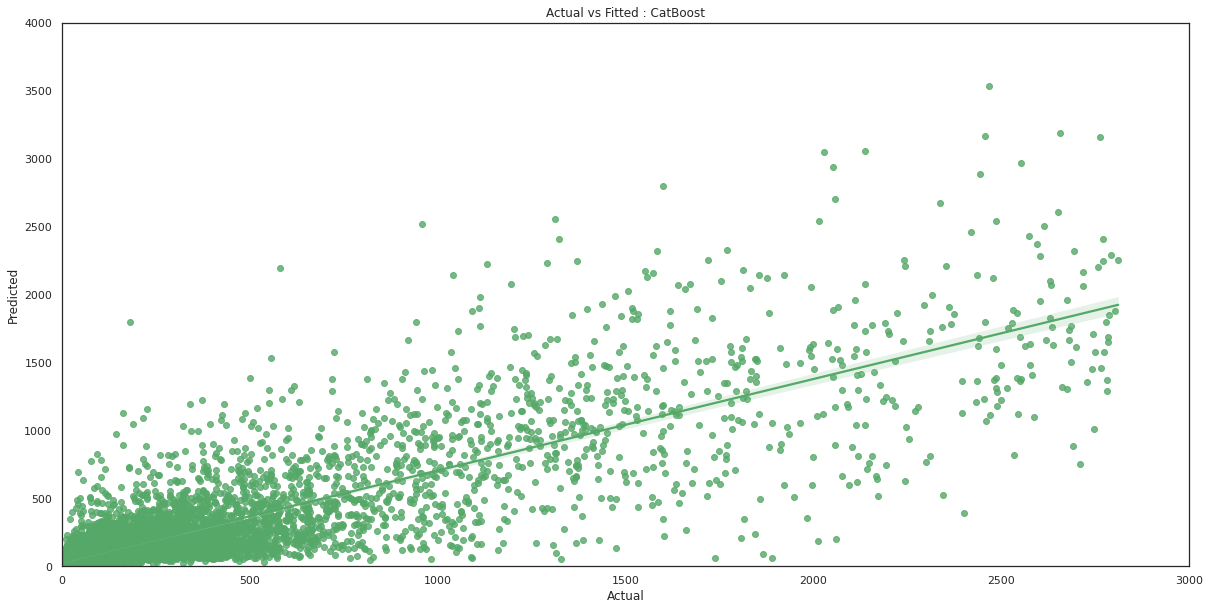

In [150]:
ax = sns.regplot(x="Actual", y="Predicted", data=data_list[data_list.Model=='catboost'], color="g")
ax.set_xlim(0,3000)
ax.set_ylim(0,4000)
ax.set_title('Actual vs Fitted : CatBoost')

In [ ]:
residuals
qq plot

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

pprint(random_grid)